### Dataset

https://cecas.clemson.edu/~ahoover/stare/

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import packages

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import os

In [3]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Imaging Techniques

/content/drive/MyDrive/Imaging Techniques


In [6]:
!ls

data  data.zip	main.ipynb


### Import data

In [7]:
codes_df =pd.read_csv('data/diagnosis_coded.csv')
diagnosis_df =pd.read_csv('data/mg_codes.csv', header =None)
diagnosis_df.columns =['image_id', 'code', 'diagnosis']

### Preview data

In [8]:
diagnosis_df.head()

,image_id,code,diagnosis
0,im0001,8,Background Diabetic Retinopathy
1,im0002,"10,4,2",Choroidal Neovascularization AND Arteriosclero...
2,im0003,"5,2",NaN
3,im0004,"4,5,2",Cilio-Retinal Artery Occlusion OR Central Reti...
4,im0005,"4,6",Central Retinal Artery Occlusion AND Central R...


### Handle Missing Values

In [9]:
diagnosis_df.isna().sum()

,0
image_id,0
code,0
diagnosis,47


In [10]:
diagnosis_df['diagnosis'] =diagnosis_df['diagnosis'].fillna('Unknown Diagnosis')

### Data Properties

In [11]:
diagnosis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   402 non-null    object
 1   code       402 non-null    object
 2   diagnosis  402 non-null    object
dtypes: object(3)
memory usage: 9.6+ KB


In [12]:
codes_df.head()

,code,diagnosis,abbreviation
0,1,Hollenhorst Emboli,Emboli
1,2,Branch Retinal Artery Occlusion,BRAO
2,3,Cilio-Retinal Artery Occlusion,CRAO
3,4,Branch Retinal Vein Occlusion,BRVO
4,5,Central Retinal Vein Occlusion,CRVO


In [13]:
codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   code          14 non-null     int64 
 1   diagnosis     14 non-null     object
 2   abbreviation  12 non-null     object
dtypes: int64(1), object(2)
memory usage: 468.0+ bytes


### Feature transformation

In [14]:
codes_df['code'] = codes_df['code'].astype(str)
diagnosis_df['code_list'] = diagnosis_df['code'].str.split(',')
all_codes = [code for sublist in diagnosis_df['code_list'].dropna() for code in sublist]
code_freq = pd.Series(all_codes).value_counts().reset_index()
code_freq.columns = ['code', 'count']
code_freq = code_freq.merge(codes_df, on='code', how='left')

### Visualize Diagnosis Frequency

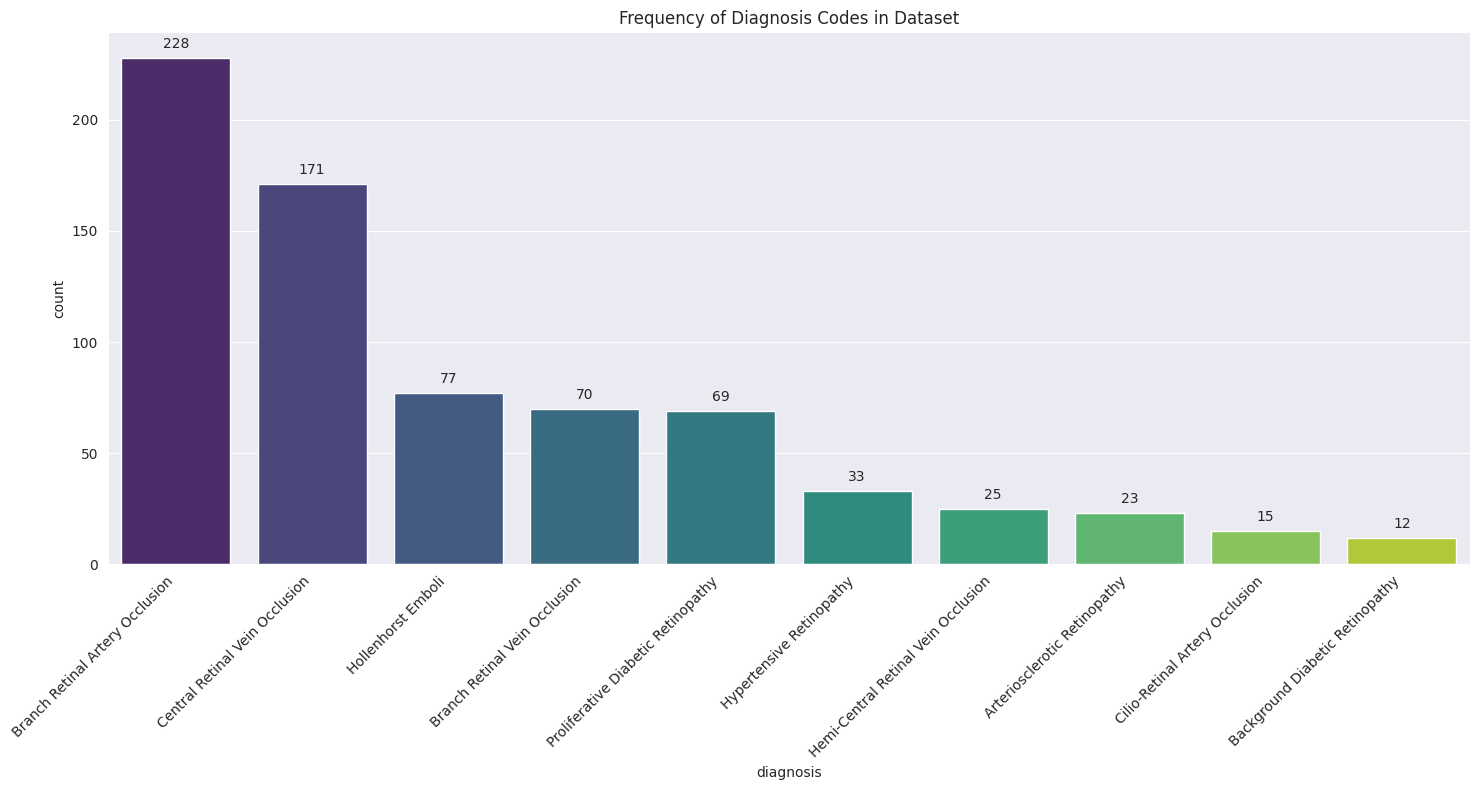

In [15]:
plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='diagnosis', y='count', data=code_freq, palette='viridis')
plt.title('Frequency of Diagnosis Codes in Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center',
            xytext = (0, 10),
            textcoords = 'offset points')
plt.show()

### Number of Diagnosis for Image

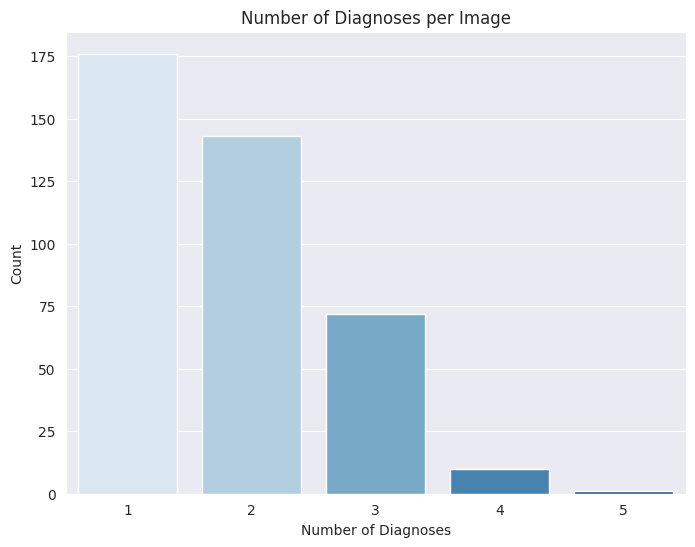

In [16]:
diagnosis_df['num_diagnoses'] = diagnosis_df['code_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
plt.figure(figsize=(8, 6))
sns.countplot(x='num_diagnoses', data=diagnosis_df, palette='Blues')
plt.title('Number of Diagnoses per Image')
plt.xlabel('Number of Diagnoses')
plt.ylabel('Count')
plt.show()

### Concurrence Diagnosis

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

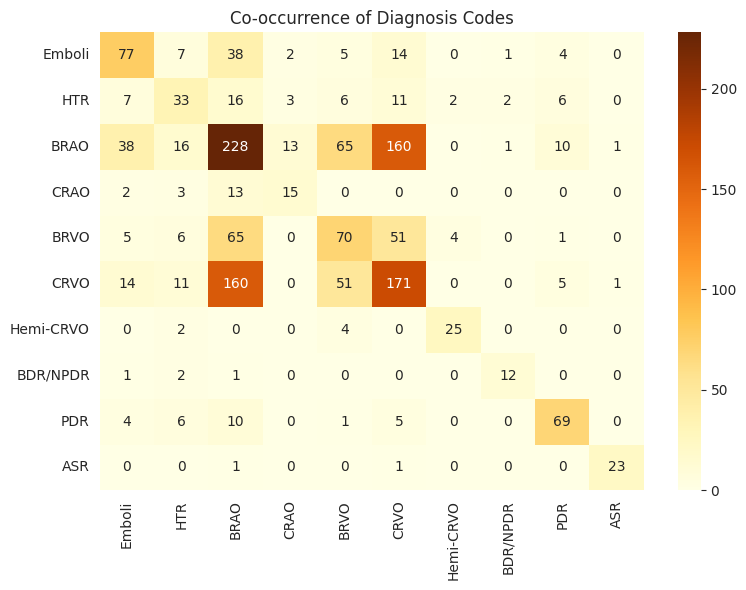

In [18]:
mlb = MultiLabelBinarizer()
code_matrix = mlb.fit_transform(diagnosis_df['code_list'])
code_df = pd.DataFrame(code_matrix, columns=mlb.classes_)
co_occurrence = code_df.T.dot(code_df)
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=[codes_df.loc[codes_df['code'] == str(c), 'abbreviation'].iloc[0] for c in co_occurrence.columns],
            yticklabels=[codes_df.loc[codes_df['code'] == str(c), 'abbreviation'].iloc[0] for c in co_occurrence.index])
plt.title('Co-occurrence of Diagnosis Codes')
plt.tight_layout()
plt.show()

In [ ]:
input_dir = "data/ppm/"
output_dir = "data/jpg/"


os.makedirs(output_dir, exist_ok=True)
image_ids = diagnosis_df['image_id'].unique().tolist()

for image_id in image_ids:
    ppm_filename = f"{image_id}.ppm"
    ppm_path = os.path.join(input_dir, ppm_filename)
    jpg_path = os.path.join(output_dir, f"{image_id}.jpg")
    if os.path.exists(ppm_path):
        try:
            img = Image.open(ppm_path)
            img.save(jpg_path, "JPEG")
        except Exception as e:
            print(f"Error converting {ppm_path}: {e}")
            blank_img = Image.new('RGB', (224, 224), (0, 0, 0))
            blank_img.save(jpg_path)
    else:
        print(f"Missing PPM file: {ppm_path}")
        blank_img = Image.new('RGB', (224, 224), (0, 0, 0))
        blank_img.save(jpg_path)

In [ ]:
def display_samples(n_samples=6, output_dir=output_dir):
    sample_df = diagnosis_df.sample(n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=(20, 5))
    if n_samples == 1:
        axes = [axes]

    for idx, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(output_dir, f"{row['image_id']}.jpg")
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            codes = row['code_list']
            diag_text = "\n".join([f"{code}: {codes_df.loc[codes_df['code'] == code, 'diagnosis'].values[0]}"
                                  for code in codes])

            axes[idx].set_title(f"ID: {row['image_id']}\nDiagnoses:\n{diag_text}")
            axes[idx].axis('off')
        except FileNotFoundError:
            axes[idx].text(0.5, 0.5, 'Image not found', ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

### Display Image Samples

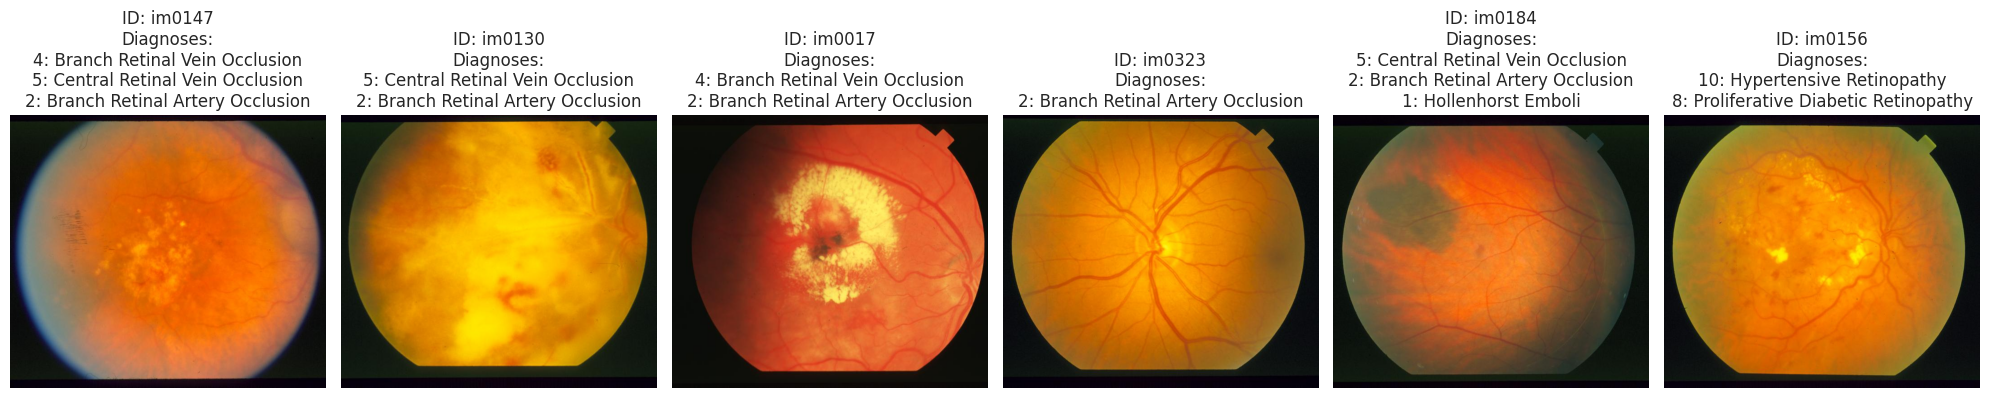

In [ ]:
display_samples()

In [ ]:
def plot_diagnosis_samples(diagnosis_code, output_dir=output_dir, n_samples=4):
    # Get images with this diagnosis
    images_with_diag = diagnosis_df[diagnosis_df['code'].str.contains(diagnosis_code, na=False)]['image_id']

    if len(images_with_diag) == 0:
        print(f"No images found for diagnosis code {diagnosis_code}")
        return

    samples = images_with_diag.sample(min(n_samples, len(images_with_diag)))

    # Get diagnosis info
    diag_info = codes_df[codes_df['code'] == diagnosis_code].iloc[0]

    # Plot images
    fig, axes = plt.subplots(1, len(samples), figsize=(12, 4))
    if len(samples) == 1:
        axes = [axes]

    fig.suptitle(f"Diagnosis: {diag_info['diagnosis']} ({diag_info['abbreviation']})", y=1.05)

    for idx, img_id in enumerate(samples):
        img_path = os.path.join(output_dir, f"{img_id}.jpg")
        try:
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(img_id)
            axes[idx].axis('off')
        except FileNotFoundError:
            axes[idx].text(0.5, 0.5, 'Image not found', ha='center')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

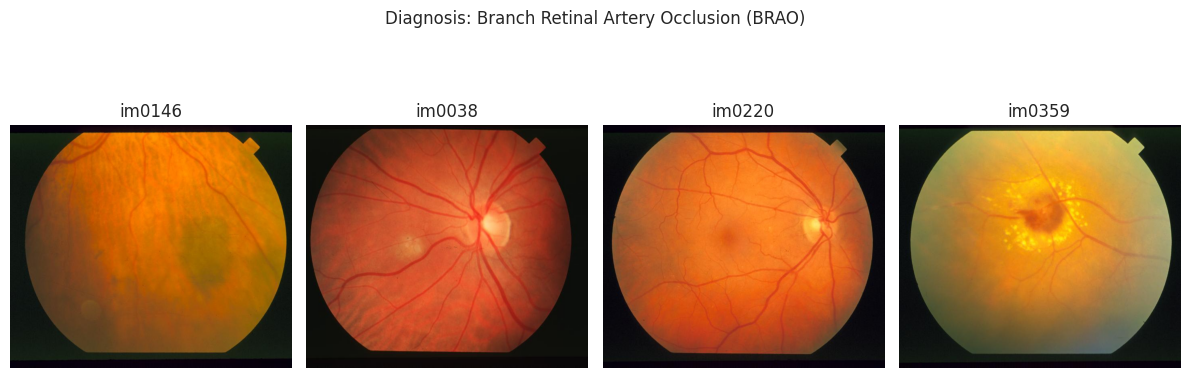

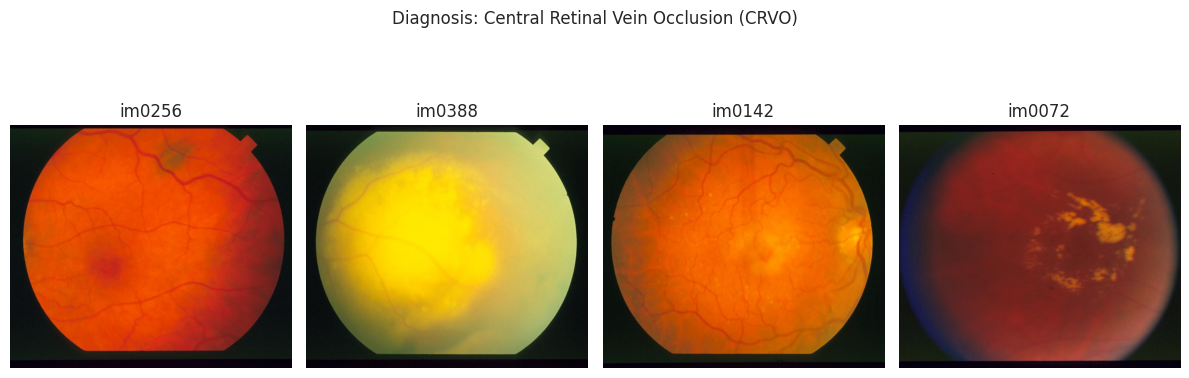

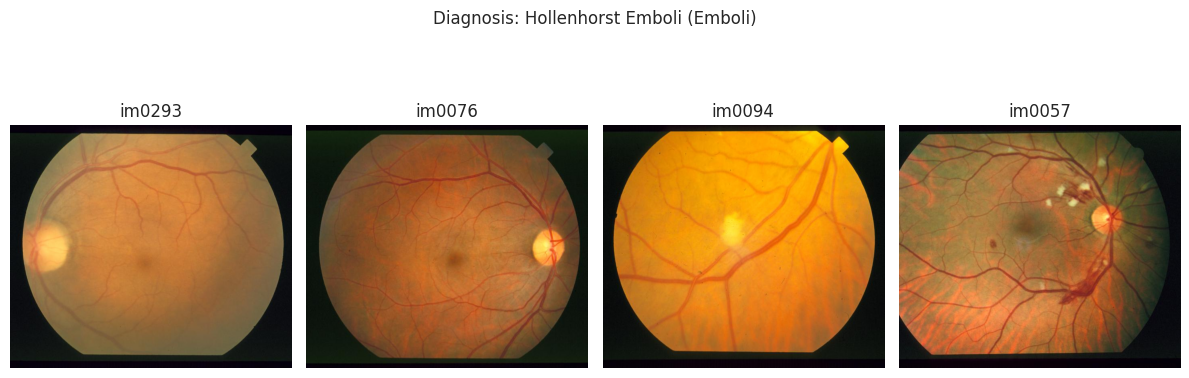

In [ ]:
for code in code_freq['code'].head(3):
    plot_diagnosis_samples(code)

In [ ]:
diagnosis_df["label"] = diagnosis_df["diagnosis"].apply(
    lambda x: 0 if "no diabetic retinopathy" in x.lower() else 1
)

In [ ]:
diagnosis_df.head()

,image_id,code,diagnosis,code_list,num_diagnoses,label
0,im0001,8,Background Diabetic Retinopathy,[8],1,1
1,im0002,"10,4,2",Choroidal Neovascularization AND Arteriosclero...,"[10, 4, 2]",3,1
2,im0003,"5,2",Unknown Diagnosis,"[5, 2]",2,1
3,im0004,"4,5,2",Cilio-Retinal Artery Occlusion OR Central Reti...,"[4, 5, 2]",3,1
4,im0005,"4,6",Central Retinal Artery Occlusion AND Central R...,"[4, 6]",2,1


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(diagnosis_df['code_list'])
image_paths = [f"{output_dir}{img_id}.jpg" for img_id in diagnosis_df["image_id"]]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
def build_data_pipeline(image_paths, labels, batch_size=32, augment=False):
    def load_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])

        image = tf.cast(image, tf.float32) / 255.0
        image = tf.keras.applications.efficientnet.preprocess_input(image)

        return image, label

    def augment_image(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)

        return image, label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = build_data_pipeline(X_train, y_train, augment=True)
val_ds = build_data_pipeline(X_val, y_val)

In [ ]:
def build_model(num_classes, base_model_trainable=False):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = base_model_trainable
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

### Build The Model

In [ ]:
num_classes = len(mlb.classes_)
model = build_model(num_classes)

In [ ]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

In [ ]:
def train_model(model, train_ds, val_ds, epochs=20):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

### Train Model

In [ ]:
model = compile_model(model)
history = train_model(model, train_ds, val_ds)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2265 - auc: 0.6297 - loss: 0.5656 - precision: 0.3179 - recall: 0.3069 - val_accuracy: 0.4938 - val_auc: 0.8113 - val_loss: 0.3788 - val_precision: 0.6173 - val_recall: 0.3356 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.4316 - auc: 0.7726 - loss: 0.4062 - precision: 0.5646 - recall: 0.2977 - val_accuracy: 0.4938 - val_auc: 0.8097 - val_loss: 0.3729 - val_precision: 0.6173 - val_recall: 0.3356 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4302 - auc: 0.7658 - loss: 0.4145 - precision: 0.5569 - recall: 0.2491 - val_accuracy: 0.4938 - val_auc: 0.8129 - val_loss: 0.3733 - val_precision: 0.6173 - val_recall: 0.3356 - learning_rate: 0.0010
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4158 - auc: 0.7776 - loss: 0.4084 - precision: 0.5257 - recall: 0.2419 - val_accuracy: 0.4938 - val_auc: 0.8110 - val_loss: 0.3715 - val_

In [ ]:
def evaluate_model(model, val_ds):
    results = model.evaluate(val_ds)
    print(f"Validation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")
    print(f"Validation Precision: {results[2]:.4f}")
    print(f"Validation Recall: {results[3]:.4f}")
    print(f"Validation AUC: {results[4]:.4f}")

### Evaluate Model

In [ ]:
evaluate_model(model, val_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4618 - auc: 0.8002 - loss: 0.3815 - precision: 0.6055 - recall: 0.3275
Validation Loss: 0.3713
Validation Accuracy: 0.4938
Validation Precision: 0.6173
Validation Recall: 0.3356
Validation AUC: 0.8129
